In [21]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset

from datasets import load_from_disk
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.001
batch_size = 128
latent_dim = 128
condition_dim = 10
gan_epochs = 50
generation_size = 1000

full_dataset = load_from_disk('../data/full_dataset_new', keep_in_memory=True)
split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

train_x_full = np.array(train_dataset['embedding'])
train_y_full = np.array(train_dataset['labels'])

test_x = np.array(test_dataset['embedding'])
test_y = np.array(test_dataset['labels'])

In [23]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x shape: (batch, input_dim) => (batch, seq_len=1, input_dim)
        x = x.unsqueeze(1)  
        out, (h, c) = self.lstm(x)  # out: (batch, 1, hidden_dim), h: (1, batch, hidden_dim)
        h_last = h[-1]
        out = self.dropout(h_last)
        out = self.fc(out)
        return out

class Generator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=10, num_classes=10, start_dim=128, n_layer=3, output_dim=512):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, condition_dim)
        input_dim = latent_dim + condition_dim
        layers = []
        layers.append(nn.Linear(input_dim, start_dim))
        layers.append(nn.ReLU(inplace=True))
        current_dim = start_dim
        
        for i in range(1, n_layer):
            next_dim = current_dim * 2
            layers.append(nn.Linear(current_dim, next_dim))
            layers.append(nn.BatchNorm1d(next_dim, momentum=0.8))
            layers.append(nn.ReLU(inplace=True))
            current_dim = next_dim
        
        layers.append(nn.Linear(current_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, condition_dim=10, num_classes=10, start_dim=512, n_layer=3, input_dim=512, dropout=0.5):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, condition_dim)
        input_dim = input_dim + condition_dim
        hidden_dim = start_dim * (2 ** (n_layer - 1))
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.LayerNorm(hidden_dim))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        layers.append(nn.Dropout(dropout))
        current_dim = hidden_dim
        for i in range(1, n_layer):
            next_dim = current_dim // 2
            layers.append(nn.Linear(current_dim, next_dim))
            layers.append(nn.LayerNorm(next_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Dropout(dropout))
            current_dim = next_dim
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([x, label_embedding], dim=1)
        return self.model(x)


def train_and_evaluate_lstm(model, train_loader, test_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_y.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
        train_loss = running_loss / total
        train_acc = correct / total
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}")

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    test_acc = accuracy_score(all_labels, all_preds)
    return test_acc, all_preds, all_labels


class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.embeddings = hf_dataset["embedding"]
        self.labels = hf_dataset["labels"]
    def __len__(self):
        return len(self.embeddings)
    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
        label = self.labels[idx]
        return emb, label

train_ds = EmbeddingDataset(train_dataset)
test_ds = EmbeddingDataset(test_dataset)

def get_loader(dataset, batch_size=32, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


[Real Data Only] Training size: 20
Training LSTM on real data...
Epoch 1: Train Loss=1.0640, Train Acc=0.3000
Epoch 2: Train Loss=0.8325, Train Acc=0.7000
Epoch 3: Train Loss=0.6491, Train Acc=0.9500
Epoch 4: Train Loss=0.5344, Train Acc=0.9500
Epoch 5: Train Loss=0.4425, Train Acc=0.9500
Epoch 6: Train Loss=0.3551, Train Acc=0.9500
Epoch 7: Train Loss=0.3305, Train Acc=0.9500
Epoch 8: Train Loss=0.2578, Train Acc=0.9500
Epoch 9: Train Loss=0.2590, Train Acc=0.9500
Epoch 10: Train Loss=0.2316, Train Acc=0.9500
LSTM Test Accuracy (Real Data) for sample size 20: 0.8735


/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_13958/210611724.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 1/50] D loss: 0.7616, G loss: 0.9337
[GAN Epoch 2/50] D loss: 0.4745, G loss: 0.9698
[GAN Epoch 3/50] D loss: 0.2689, G loss: 1.5024
[GAN Epoch 4/50] D loss: 0.1901, G loss: 1.7785
[GAN Epoch 5/50] D loss: 0.1546, G loss: 2.1806
[GAN Epoch 6/50] D loss: 0.0947, G loss: 2.5995
[GAN Epoch 7/50] D loss: 0.0678, G loss: 2.6877
[GAN Epoch 8/50] D loss: 0.0714, G loss: 2.7860
[GAN Epoch 9/50] D loss: 0.0583, G loss: 2.9162
[GAN Epoch 10/50] D loss: 0.0561, G loss: 2.9908
[GAN Epoch 11/50] D loss: 0.0454, G loss: 3.1052
[GAN Epoch 12/50] D loss: 0.0467, G loss: 3.0058
[GAN Epoch 13/50] D loss: 0.0526, G loss: 3.1053
[GAN Epoch 14/50] D loss: 0.0523, G loss: 2.9348
[GAN Epoch 15/50] D loss: 0.0491, G loss: 2.9807
[GAN Epoch 16/50] D loss: 0.0494, G loss: 3.0717
[GAN Epoch 17/50] D loss: 0.0513, G loss: 2.8831
[GAN Epoch 18/50] D loss: 0.0438, G loss: 2.8563
[GAN Epoch 19/50] D loss: 0.0455, G loss: 2.8897
[GAN Epoch 20/50] D loss: 0.0699, G loss: 3.1179
[GAN Epoch 21/50] D loss: 0.0

/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_13958/210611724.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 24/50] D loss: 0.0325, G loss: 3.5656
[GAN Epoch 25/50] D loss: 0.0339, G loss: 3.4944
[GAN Epoch 26/50] D loss: 0.0475, G loss: 3.2814
[GAN Epoch 27/50] D loss: 0.0344, G loss: 3.7831
[GAN Epoch 28/50] D loss: 0.0327, G loss: 3.7432
[GAN Epoch 29/50] D loss: 0.0259, G loss: 3.8640
[GAN Epoch 30/50] D loss: 0.0335, G loss: 3.7673
[GAN Epoch 31/50] D loss: 0.0282, G loss: 4.4380
[GAN Epoch 32/50] D loss: 0.0270, G loss: 4.0994
[GAN Epoch 33/50] D loss: 0.0241, G loss: 4.1918
[GAN Epoch 34/50] D loss: 0.0234, G loss: 4.5131
[GAN Epoch 35/50] D loss: 0.0176, G loss: 4.2669
[GAN Epoch 36/50] D loss: 0.0268, G loss: 4.1738
[GAN Epoch 37/50] D loss: 0.0144, G loss: 4.5504
[GAN Epoch 38/50] D loss: 0.0176, G loss: 4.5375
[GAN Epoch 39/50] D loss: 0.0183, G loss: 4.4009
[GAN Epoch 40/50] D loss: 0.0287, G loss: 4.2041
[GAN Epoch 41/50] D loss: 0.0178, G loss: 4.5746
[GAN Epoch 42/50] D loss: 0.0138, G loss: 4.7246
[GAN Epoch 43/50] D loss: 0.0214, G loss: 4.5593
[GAN Epoch 44/50] D 

/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_13958/210611724.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 24/50] D loss: 0.0711, G loss: 3.1398
[GAN Epoch 25/50] D loss: 0.0563, G loss: 4.2847
[GAN Epoch 26/50] D loss: 0.0308, G loss: 3.7317
[GAN Epoch 27/50] D loss: 0.0377, G loss: 3.5750
[GAN Epoch 28/50] D loss: 0.0282, G loss: 4.2953
[GAN Epoch 29/50] D loss: 0.0204, G loss: 4.2554
[GAN Epoch 30/50] D loss: 0.0268, G loss: 4.0105
[GAN Epoch 31/50] D loss: 0.0358, G loss: 3.7160
[GAN Epoch 32/50] D loss: 0.0609, G loss: 4.0434
[GAN Epoch 33/50] D loss: 0.0437, G loss: 4.4958
[GAN Epoch 34/50] D loss: 0.0391, G loss: 3.5321
[GAN Epoch 35/50] D loss: 0.0178, G loss: 4.6166
[GAN Epoch 36/50] D loss: 0.0143, G loss: 4.6983
[GAN Epoch 37/50] D loss: 0.0150, G loss: 4.6569
[GAN Epoch 38/50] D loss: 0.0248, G loss: 4.2340
[GAN Epoch 39/50] D loss: 0.0232, G loss: 4.6937
[GAN Epoch 40/50] D loss: 0.0206, G loss: 4.8029
[GAN Epoch 41/50] D loss: 0.0154, G loss: 4.7622
[GAN Epoch 42/50] D loss: 0.0234, G loss: 4.5138
[GAN Epoch 43/50] D loss: 0.0164, G loss: 4.7921
[GAN Epoch 44/50] D 

/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_13958/210611724.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 25/50] D loss: 0.0393, G loss: 3.8684
[GAN Epoch 26/50] D loss: 0.0272, G loss: 4.0412
[GAN Epoch 27/50] D loss: 0.0263, G loss: 4.0835
[GAN Epoch 28/50] D loss: 0.0289, G loss: 3.9257
[GAN Epoch 29/50] D loss: 0.0238, G loss: 4.1550
[GAN Epoch 30/50] D loss: 0.0280, G loss: 4.1065
[GAN Epoch 31/50] D loss: 0.0214, G loss: 4.2920
[GAN Epoch 32/50] D loss: 0.0286, G loss: 4.1714
[GAN Epoch 33/50] D loss: 0.0263, G loss: 4.2779
[GAN Epoch 34/50] D loss: 0.0182, G loss: 4.6739
[GAN Epoch 35/50] D loss: 0.0197, G loss: 4.2445
[GAN Epoch 36/50] D loss: 0.0179, G loss: 4.6004
[GAN Epoch 37/50] D loss: 0.0178, G loss: 4.2982
[GAN Epoch 38/50] D loss: 0.0165, G loss: 4.5792
[GAN Epoch 39/50] D loss: 0.0228, G loss: 4.4469
[GAN Epoch 40/50] D loss: 0.0198, G loss: 4.8910
[GAN Epoch 41/50] D loss: 0.0127, G loss: 4.9370
[GAN Epoch 42/50] D loss: 0.0131, G loss: 4.4949
[GAN Epoch 43/50] D loss: 0.0185, G loss: 4.6018
[GAN Epoch 44/50] D loss: 0.0165, G loss: 5.0845
[GAN Epoch 45/50] D 

/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_13958/210611724.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 1/50] D loss: 0.4427, G loss: 1.1953
[GAN Epoch 2/50] D loss: 0.0984, G loss: 2.3998
[GAN Epoch 3/50] D loss: 0.0499, G loss: 2.9642
[GAN Epoch 4/50] D loss: 0.0469, G loss: 2.9723
[GAN Epoch 5/50] D loss: 0.0437, G loss: 3.1310
[GAN Epoch 6/50] D loss: 0.0430, G loss: 3.4188
[GAN Epoch 7/50] D loss: 0.0446, G loss: 3.3414
[GAN Epoch 8/50] D loss: 0.0429, G loss: 3.6127
[GAN Epoch 9/50] D loss: 0.0354, G loss: 3.7636
[GAN Epoch 10/50] D loss: 0.0382, G loss: 3.7326
[GAN Epoch 11/50] D loss: 0.0327, G loss: 4.0564
[GAN Epoch 12/50] D loss: 0.0290, G loss: 4.3470
[GAN Epoch 13/50] D loss: 0.0178, G loss: 4.2226
[GAN Epoch 14/50] D loss: 0.0209, G loss: 4.3632
[GAN Epoch 15/50] D loss: 0.0196, G loss: 4.4502
[GAN Epoch 16/50] D loss: 0.0366, G loss: 4.3854
[GAN Epoch 17/50] D loss: 0.0106, G loss: 4.9467
[GAN Epoch 18/50] D loss: 0.0173, G loss: 4.7832
[GAN Epoch 19/50] D loss: 0.0226, G loss: 4.8020
[GAN Epoch 20/50] D loss: 0.0137, G loss: 5.0494
[GAN Epoch 21/50] D loss: 0.0

/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 6: Train Loss=0.2384, Train Acc=0.9200
Epoch 7: Train Loss=0.2300, Train Acc=0.9180
Epoch 8: Train Loss=0.2238, Train Acc=0.9210
Epoch 9: Train Loss=0.2126, Train Acc=0.9240
Epoch 10: Train Loss=0.2131, Train Acc=0.9280
LSTM Test Accuracy (Real Data) for sample size 1000: 0.9065
[GAN Epoch 1/50] D loss: 0.2180, G loss: 2.0246


/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_13958/210611724.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 2/50] D loss: 0.0457, G loss: 3.0411
[GAN Epoch 3/50] D loss: 0.0490, G loss: 3.4513
[GAN Epoch 4/50] D loss: 0.0392, G loss: 3.9550
[GAN Epoch 5/50] D loss: 0.0247, G loss: 4.4399
[GAN Epoch 6/50] D loss: 0.0230, G loss: 4.5910
[GAN Epoch 7/50] D loss: 0.0193, G loss: 4.8687
[GAN Epoch 8/50] D loss: 0.0445, G loss: 4.7824
[GAN Epoch 9/50] D loss: 0.2356, G loss: 5.1171
[GAN Epoch 10/50] D loss: 0.0285, G loss: 4.8225
[GAN Epoch 11/50] D loss: 0.5385, G loss: 3.5541
[GAN Epoch 12/50] D loss: 0.1057, G loss: 3.0881
[GAN Epoch 13/50] D loss: 0.4397, G loss: 3.1158
[GAN Epoch 14/50] D loss: 0.0899, G loss: 3.2740
[GAN Epoch 15/50] D loss: 0.0791, G loss: 4.0258
[GAN Epoch 16/50] D loss: 0.0458, G loss: 4.2730
[GAN Epoch 17/50] D loss: 0.0431, G loss: 4.3091
[GAN Epoch 18/50] D loss: 0.0355, G loss: 4.4217
[GAN Epoch 19/50] D loss: 0.0448, G loss: 4.4106
[GAN Epoch 20/50] D loss: 0.0570, G loss: 4.3172
[GAN Epoch 21/50] D loss: 0.1597, G loss: 4.3694
[GAN Epoch 22/50] D loss: 0.

/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 2: Train Loss=0.2396, Train Acc=0.9121
Epoch 3: Train Loss=0.2414, Train Acc=0.9108
Epoch 4: Train Loss=0.2342, Train Acc=0.9132
Epoch 5: Train Loss=0.2281, Train Acc=0.9163
Epoch 6: Train Loss=0.2261, Train Acc=0.9153
Epoch 7: Train Loss=0.2255, Train Acc=0.9167
Epoch 8: Train Loss=0.2226, Train Acc=0.9179
Epoch 9: Train Loss=0.2212, Train Acc=0.9168
Epoch 10: Train Loss=0.2176, Train Acc=0.9176
LSTM Test Accuracy (Real Data) for sample size 7872: 0.9070


/tmp/ipykernel_13958/4182515367.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_13958/210611724.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 1/50] D loss: 0.0715, G loss: 3.9369
[GAN Epoch 2/50] D loss: 0.2821, G loss: 4.0372
[GAN Epoch 3/50] D loss: 0.1472, G loss: 3.6659
[GAN Epoch 4/50] D loss: 0.0723, G loss: 3.8443
[GAN Epoch 5/50] D loss: 0.2110, G loss: 3.1873
[GAN Epoch 6/50] D loss: 0.1736, G loss: 2.8686
[GAN Epoch 7/50] D loss: 0.2287, G loss: 2.6405
[GAN Epoch 8/50] D loss: 0.2669, G loss: 2.3948
[GAN Epoch 9/50] D loss: 0.2636, G loss: 2.3059
[GAN Epoch 10/50] D loss: 0.3114, G loss: 2.0877
[GAN Epoch 11/50] D loss: 0.2915, G loss: 2.1208
[GAN Epoch 12/50] D loss: 0.3364, G loss: 1.9332
[GAN Epoch 13/50] D loss: 0.3876, G loss: 1.7555
[GAN Epoch 14/50] D loss: 0.3982, G loss: 1.7232
[GAN Epoch 15/50] D loss: 0.4104, G loss: 1.6793
[GAN Epoch 16/50] D loss: 0.4084, G loss: 1.7160
[GAN Epoch 17/50] D loss: 0.3944, G loss: 1.7189
[GAN Epoch 18/50] D loss: 0.4150, G loss: 1.6768
[GAN Epoch 19/50] D loss: 0.4318, G loss: 1.5959
[GAN Epoch 20/50] D loss: 0.4350, G loss: 1.5872
[GAN Epoch 21/50] D loss: 0.4

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


Epoch 10: Train Loss=0.4588, Train Acc=0.7781
LSTM Test Accuracy (After Concatenation) for sample size 7872: 0.9136
Accuracy Summary:
╒═════════════════╤══════════════════════╤════════════════════════════════╕
│   Train Samples │   Real Only Accuracy │   After Concatenation Accuracy │
╞═════════════════╪══════════════════════╪════════════════════════════════╡
│              20 │             0.873476 │                       0.841972 │
├─────────────────┼──────────────────────┼────────────────────────────────┤
│              50 │             0.892785 │                       0.869919 │
├─────────────────┼──────────────────────┼────────────────────────────────┤
│              70 │             0.888211 │                       0.893293 │
├─────────────────┼──────────────────────┼────────────────────────────────┤
│             100 │             0.892276 │                       0.894309 │
├─────────────────┼──────────────────────┼────────────────────────────────┤
│             300 │           

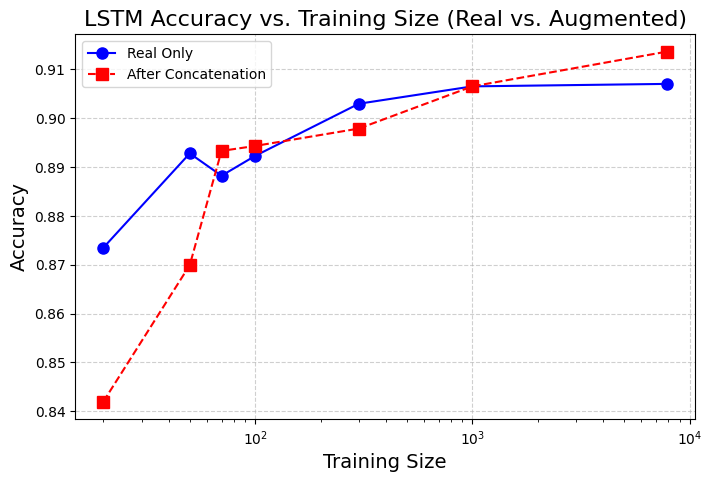

In [24]:
sample_sizes = [20, 50, 70, 100, 300, 1000, len(train_ds)]
lstm_accuracy_before = {}
lstm_accuracy_after = {}

for size in sample_sizes:
    print(f"\n[Real Data Only] Training size: {size}")
    train_subset = Subset(train_ds, range(size))
    train_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = get_loader(test_ds, batch_size=batch_size, shuffle=False)

    input_dim = train_ds[0][0].shape[0]  
    hidden_dim = 128
    num_classes = len(np.unique(train_y_full)) 

    lstm_model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=0.5)
    lstm_model.to(device)

    print("Training LSTM on real data...")
    acc_before, preds_before, labels_before = train_and_evaluate_lstm(
        lstm_model, train_loader, test_loader, num_epochs, learning_rate, device
    )
    print(f"LSTM Test Accuracy (Real Data) for sample size {size}: {acc_before:.4f}")
    lstm_accuracy_before[size] = acc_before

    generator = Generator(
        latent_dim=latent_dim,
        condition_dim=condition_dim,
        num_classes=num_classes,
        start_dim=latent_dim * 2,
        n_layer=3,
        output_dim=input_dim
    ).to(device)
    discriminator = Discriminator(
        condition_dim=condition_dim,
        num_classes=num_classes,
        start_dim=256,
        n_layer=3,
        input_dim=input_dim
    ).to(device)

    adversarial_loss = nn.BCELoss().to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=5e-5, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.5, 0.999))

    gan_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)
    for epoch in range(gan_epochs):
        d_loss_epoch, g_loss_epoch = 0.0, 0.0
        for embeddings, labels in gan_loader:
            embeddings = embeddings.to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)
            b_size = embeddings.size(0)

            valid = torch.ones(b_size, 1, device=device)
            fake = torch.zeros(b_size, 1, device=device)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(b_size, latent_dim, device=device)
            gen_data = generator(z, labels)
            g_loss = adversarial_loss(discriminator(gen_data, labels), valid)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(embeddings, labels), valid)
            fake_loss = adversarial_loss(discriminator(gen_data.detach(), labels), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()

        print(f"[GAN Epoch {epoch+1}/{gan_epochs}] D loss: {d_loss_epoch/len(gan_loader):.4f}, G loss: {g_loss_epoch/len(gan_loader):.4f}")

    synthetic_data_list = []
    synthetic_labels_list = []
    unique_labels = np.unique(train_y_full)
    for lab in unique_labels:
        lab_tensor = torch.full((generation_size,), lab, dtype=torch.long, device=device)
        z = torch.randn(generation_size, latent_dim, device=device)
        synth = generator(z, lab_tensor).cpu().detach().numpy()
        synthetic_data_list.append(synth)
        synthetic_labels_list.append(np.full((generation_size,), lab))

    synthetic_x = np.concatenate(synthetic_data_list, axis=0)
    synthetic_y = np.concatenate(synthetic_labels_list, axis=0)

    X_train = train_x_full[:size]
    y_train = train_y_full[:size]
    train_combined_x = np.concatenate([X_train, synthetic_x], axis=0)
    train_combined_y = np.concatenate([y_train, synthetic_y], axis=0)

    train_combined_dataset = TensorDataset(
        torch.tensor(train_combined_x, dtype=torch.float),
        torch.tensor(train_combined_y, dtype=torch.long)
    )
    train_combined_loader = DataLoader(train_combined_dataset, batch_size=batch_size, shuffle=True)

    lstm_model_aug = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=0.5)
    lstm_model_aug.to(device)

    print("Training LSTM on real + synthetic (concatenated) data...")
    acc_after, preds_after, labels_after = train_and_evaluate_lstm(
        lstm_model_aug, train_combined_loader, test_loader, num_epochs, learning_rate, device
    )
    print(f"LSTM Test Accuracy (After Concatenation) for sample size {size}: {acc_after:.4f}")
    lstm_accuracy_after[size] = acc_after

summary_df = pd.DataFrame(
    [[s, lstm_accuracy_before[s], lstm_accuracy_after[s]] for s in sample_sizes],
    columns=["Train Samples", "Real Only Accuracy", "After Concatenation Accuracy"]
)

print("Accuracy Summary:")
print(tabulate.tabulate(summary_df.values, headers=summary_df.columns, tablefmt="fancy_grid"))

plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, list(lstm_accuracy_before.values()), marker='o', linestyle='-', color='b', markersize=8, label="Real Only")
plt.plot(sample_sizes, list(lstm_accuracy_after.values()), marker='s', linestyle='--', color='r', markersize=8, label="After Concatenation")
plt.xlabel("Training Size", fontsize=14, fontfamily="Times New Roman")
plt.ylabel("Accuracy", fontsize=14, fontfamily="Times New Roman")
plt.title("LSTM Accuracy vs. Training Size (Real vs. Augmented)", fontsize=16, fontfamily="Times New Roman")
plt.xscale("log")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()